In [1]:
%run ./Definitions.ipynb

2019-12-18 16:57:37.589977
thunder  Wed Dec 18 16:57:37 2019
[0] GeForce GTX 1080 Ti | 39'C,   0 % |   284 / 11178 MB | hemelinr(274M)
[1] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 59'C,  43 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 56'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[4] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 61'C,  38 % | 10895 / 11178 MB | patra(10885M)
[7] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "7"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

Wed Dec 18 16:57:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P2    56W / 250W |    284MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Loading train data to use in Random Forest

In [3]:
tts_path = DATA_dir+'TrainTestVal/'
enc_df = pd.read_pickle(DATA_dir + 'enc_df.pkl')
y_train_df = pd.read_pickle(tts_path + 'y_train.pkl')
y_val_df = pd.read_pickle(tts_path + 'y_val.pkl')

#### Converting the labels to list and assign 0 label to non glaucoma (2 or 3 mismatch)

In [22]:
y_train = y_train_df['ClassLabel'].tolist()
y_val = y_val_df['ClassLabel'].tolist()

for i in range(len(y_train)):
    if(y_train[i] != 1):
        y_train[i] = 0
        
for i in range(len(y_val)):
    if(y_val[i] != 1):
        y_val[i] = 0


In [23]:
indices_train = np.load(tts_path + 'indices_train.npy')
indices_val = np.load(tts_path + 'indices_val.npy')
indices_test = np.load(tts_path + 'indices_test.npy')

In [24]:
enc_df.shape, len(y_train), len(y_val)

((85730, 6251), 51438, 17146)

## Class Distribution

#### No. of Glaucoma and non Glaucoma patients in training set

In [25]:
n_NG = 0
n_G = 0

for i in range(len(y_train)):
    if(y_train[i] == 1):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 389
No. of non-Glaucoma patients in training set: 51049


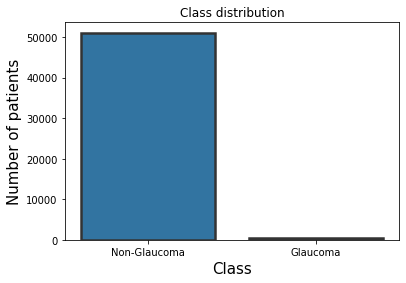

In [26]:
import seaborn as sns

class_name = ['Non-Glaucoma', 'Glaucoma']
count = [n_NG, n_G]
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.title('Class distribution')
plt.show()

## Assigning class weight for imbalance data set to use in Random forest classifier

In [27]:
class_weight = dict({0:1, 1:150})

## Feature Reduction and Saving Dataframe with reduced features

In [9]:
# cols2rem = ['87-','92-','135-','2227-','4689-','5181-','5326-','5327-','5945-','6119-','6148-','20002-','20008-','20009-','20010-','20011','20013-',
#             '20014-','40001-','40002-','41078-','41080-','41082-','41083-','41084-','41096-','41101-','41142-','41202-','41204-',
#             '41200-','41210-']

# # len(cols2rem) # 13
# remove_df  = enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[0])]
# for i in range(1,len(cols2rem)):
#     remove_df = remove_df.join(enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[i])])
    
# new_enc_df = enc_df.drop(remove_df.columns, axis=1)
# new_enc_df.shape

(85730, 4898)

### Spliting new_enc_df to train test val as per the indices

In [98]:
# meta_train = []
# meta_val = []
# meta_test = []

# for i in range(len(indices_train)):
#     meta_train.append(new_enc_df.iloc[indices_train[i]])
    
# for i in range(len(indices_val)):
#     meta_val.append(new_enc_df.iloc[indices_val[i]])
#     meta_test.append(new_enc_df.iloc[indices_test[i]])

# meta_train_arr = np.asarray(meta_train)
# meta_val_arr = np.asarray(meta_val)
# meta_test_arr = np.asarray(meta_test)

# meta_train_df = pd.DataFrame(meta_train_arr,columns = new_enc_df.columns)
# meta_val_df = pd.DataFrame(meta_val_arr,columns = new_enc_df.columns)
# meta_test_df = pd.DataFrame(meta_test_arr,columns = new_enc_df.columns)

In [100]:
# #SAVE - DONE
# meta_train_df.to_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
# meta_val_df.to_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
# meta_test_df.to_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

### Loading Reduced Features Encodeded Metadata - Train and Validation

In [28]:
meta_train_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
meta_val_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_val.pkl')

meta_train_df.shape, meta_val_df.shape, len(y_train), len(y_val)

((51438, 4898), (17146, 4898), 51438, 17146)

## RandomForestClassifier for Feature Importance

#### 1. Without class weights - everything is classified as majority class - High accuracy but 0 precision and recall

In [215]:
# # # Random forest classifier
# rfc_all = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_all.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [217]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_all, tts_path + 'RandomForest_allfeat.sav')

['/ds2/data/retina/UK_BB/patra/TrainTestVal/RandomForest_allfeat.sav']

In [14]:
rfc_all = joblib.load(tts_path + 'RandomForest_allfeat.sav')

#### 2. With class weights - giving higher weight to minority class

In [29]:
# rfc_all_cw = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)

rfc_all_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

In [30]:
rfc_all_cw.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 150},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Feature Dictionaries

In [31]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [32]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_all_cw, meta_train_df)

In [33]:
pd.options.display.max_colwidth = 100

fi_red = get_imp_features(50)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.019535
1,Year of birth,0.017447
2,Age when attended assessment centre,0.017066
3,Corneal hysteresis (right),0.011003
4,Corneal hysteresis (left),0.010730
5,Intra-ocular pressure device ID (left),0.010117
6,Duration visual-acuity screen displayed (right),0.007348
7,"Intra-ocular pressure, corneal-compensated (right)",0.006941
8,"Intra-ocular pressure, Goldmann-correlated (left)",0.006546
9,Time since interview start at which blood pressure screen(s) shown,0.006395


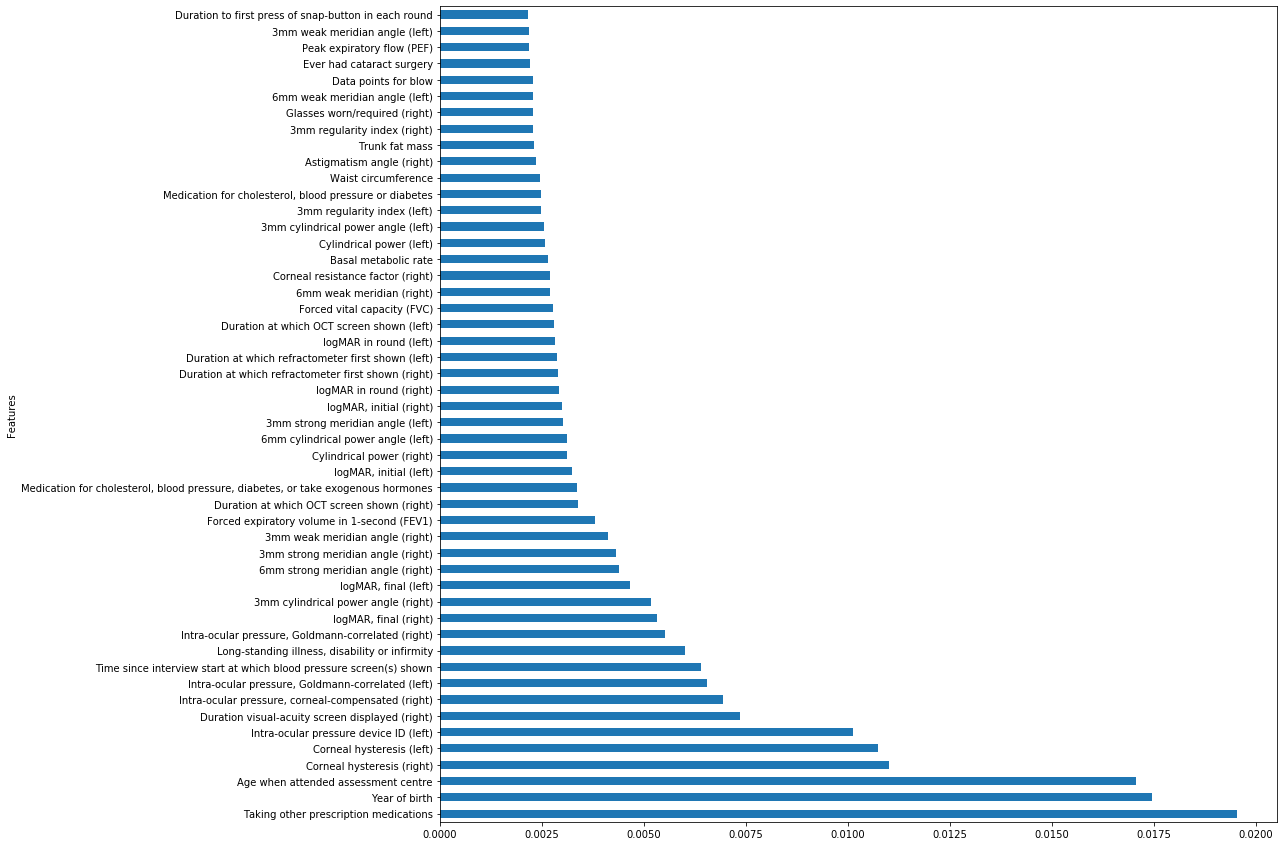

In [34]:
def plot_fi(finew):
    return finew.plot('Features','Importance','barh',figsize=(15,15),legend=False)

plot_fi(fi_red)

## Creating Dataframe containing important features

In [35]:
# Getting feature from feature description
feat_to_keep = fi_red[fi_red.Importance>0.0022].Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

47

In [36]:
meta_train_df.shape, meta_val_df.shape

((51438, 4898), (17146, 4898))

In [37]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i])])
    
redtrain_df.shape

(51438, 383)

In [38]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i])])
    
redval_df.shape

(17146, 383)

### Saving the dataframe

In [39]:
redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_train_df.pkl')
redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_val_df.pkl')

## Applying Random Forest Classifier to see the correlation among these selected features

In [40]:
# LOAD
redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_train_df.pkl')
redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_val_df.pkl')
redtrain_df.shape, redval_df.shape

((51438, 383), (17146, 383))

#### without class_weight

In [219]:
# rfc_red = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_red.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [220]:
# Saving -- DONE !!
from sklearn.externals import joblib
joblib.dump(rfc_red, tts_path + 'RandomForest_redfeat.sav')

['/ds2/data/retina/UK_BB/patra/TrainTestVal/RandomForest_redfeat.sav']

#### with class weight

In [41]:
rfc_red_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

rfc_red_cw.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 150},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Loading Reduced features random forest

In [221]:
# rfc_red = joblib.load(tts_path + 'RandomForest_redfeat.sav')

In [42]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [43]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_red_cw, redtrain_df)
fi_red = get_imp_features(40)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.058557
1,Age when attended assessment centre,0.047556
2,Year of birth,0.041455
3,Corneal hysteresis (left),0.035624
4,"Intra-ocular pressure, corneal-compensated (right)",0.024997
5,Corneal hysteresis (right),0.023045
6,Duration visual-acuity screen displayed (right),0.019708
7,Time since interview start at which blood pressure screen(s) shown,0.016662
8,"Intra-ocular pressure, Goldmann-correlated (left)",0.016585
9,"Intra-ocular pressure, Goldmann-correlated (right)",0.014989


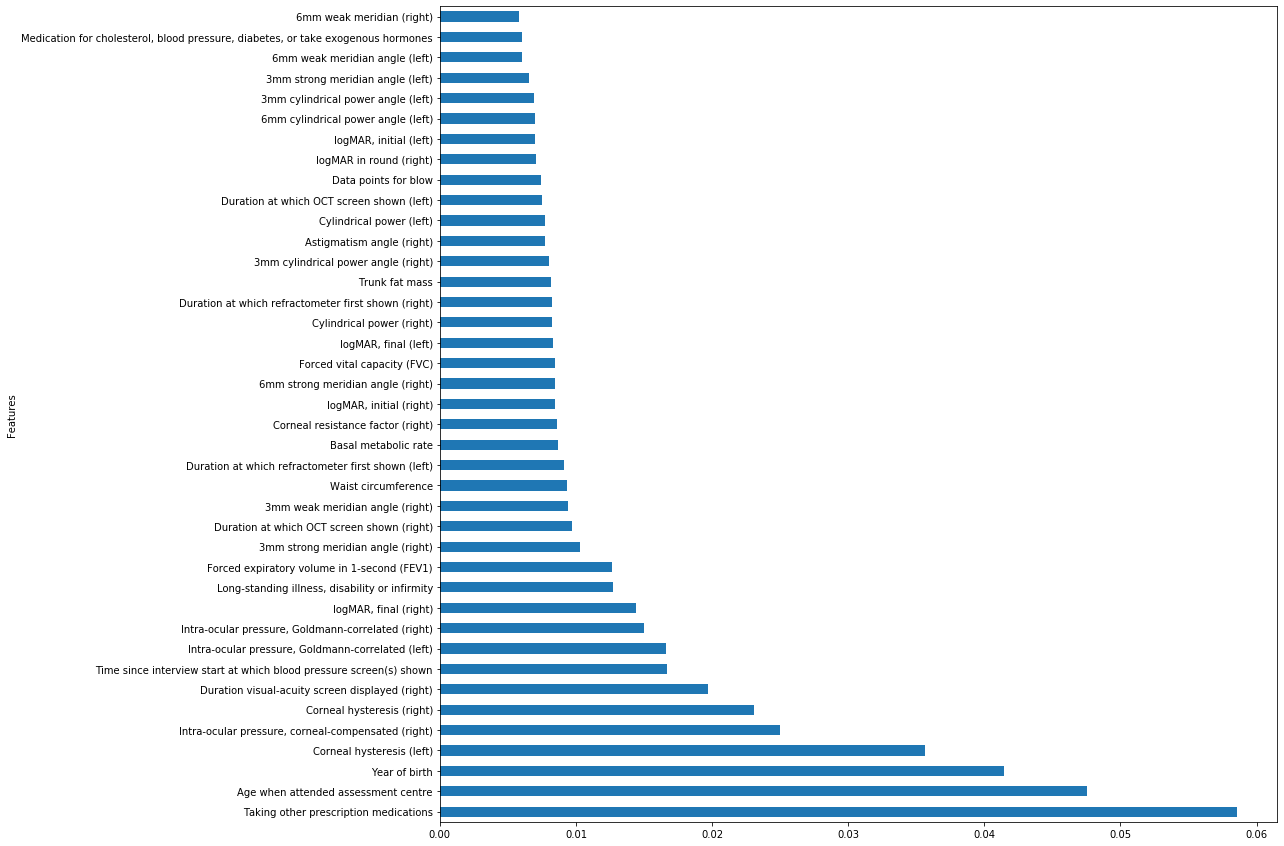

In [44]:
plot_fi(fi_red)

## Compare The Accuracy Of Full Feature Classifier To Limited Feature Classifier


In [51]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# Full Featured Classifier To The Test Data
y_pred = rfc_all_cw.predict(meta_val_df)
y_important_pred = rfc_red_cw.predict(redval_df)

#### F1 score

In [36]:
# 40 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.08037825059101655, 0.09006622516556292)

In [46]:
# 47 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.0743919885550787, 0.08247422680412372)

#### Accuracy score

In [232]:
#WITHOUT CLASS WEIGHTS

# accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)
# (0.9928846378164004, 0.9928846378164004)


(0.9928846378164004, 0.9928846378164004)

In [35]:
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.9773124927096699, 0.9599323457366149)

In [47]:
# 47 features
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.962265251370582, 0.9480928496442319)

#### Recall score

In [37]:
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.13934426229508196, 0.2786885245901639)

In [48]:
# 47 features
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.21311475409836064, 0.32786885245901637)

#### Precision score

In [38]:
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(0.05647840531561462, 0.053712480252764615)

In [49]:
# 47 features
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(0.045060658578856154, 0.04716981132075472)

#### classification_report

In [56]:
# 47 features
print(classification_report(y_val, y_pred) ,"\n\n", classification_report(y_val, y_important_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17024
           1       0.05      0.21      0.07       122

    accuracy                           0.96     17146
   macro avg       0.52      0.59      0.53     17146
weighted avg       0.99      0.96      0.97     17146
 

               precision    recall  f1-score   support

           0       0.99      0.95      0.97     17024
           1       0.05      0.33      0.08       122

    accuracy                           0.95     17146
   macro avg       0.52      0.64      0.53     17146
weighted avg       0.99      0.95      0.97     17146



#### Confusion matrix

In [55]:
# 47 features
# tn, fp, fn, tp
print(confusion_matrix(y_val, y_pred) ,"\n\n", confusion_matrix(y_val, y_important_pred))

[[16473   551]
 [   96    26]] 

 [[16216   808]
 [   82    40]]
